In [1]:
!pip install pennylane

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
from collections import Counter
import heapq
from collections import defaultdict

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [3]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance in miles"""
    from math import radians, sin, cos, sqrt, atan2
    R = 3959  # Earth radius in miles
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c


In [4]:


def generate_network():
    hubs = {
        'JFK': (40.64, -73.78),  
        'BOS': (42.36, -71.01),  
        'ATL': (33.64, -84.43),  
        'MIA': (25.79, -80.29)   
    }
    hub_names = list(hubs.keys())
    flights = []
    
    base_time = datetime(2025,12,3,8,0)
    for i, orig in enumerate(hub_names):
        for j, dest in enumerate(hub_names):
            if orig == dest: continue
            
            # Distance → duration
            dist = abs(i-j)*300 + np.random.uniform(50,150)  # ~600-1200 miles
            duration = dist/500 + 0.5
            
            # 2 flights per route (morning + afternoon)
            for offset in [0, 6]:  # 6h spacing
                dep = base_time + timedelta(hours=offset)
                arr = dep + timedelta(hours=duration)
                cost = dist*0.8 + duration*50
                
                flights.append({
                    'flight_id': len(flights),
                    'origin': orig,
                    'destination': dest,
                    'departure_time': dep,
                    'arrival_time': arr,
                    'duration_hours': duration,
                    'cost': cost,
                    'handling_time': 1.5
                })
    
    df = pd.DataFrame(flights)
    print(f"✅ Generated {len(df)} flights (16 qubits!) across 4 hubs")
    return df
flights_16qubit = generate_network()
scenario_16qubit = {'origin': 'JFK', 'destination': 'MIA', 'max_time': 12.0}
print(f"Scenario: {scenario_16qubit['origin']} → {scenario_16qubit['destination']} ({scenario_16qubit['max_time']}h)")
flights_16qubit = flights_16qubit.head(16).copy()


✅ Generated 24 flights (16 qubits!) across 4 hubs
Scenario: JFK → MIA (12.0h)


In [5]:
# flights = generate_network()
scenario = {'origin': 'JFK', 'destination': 'MIA', 'max_time': 12.0}
print(f"Scenario: {scenario['origin']} → {scenario['destination']} ({scenario['max_time']}h)")

Scenario: JFK → MIA (12.0h)


In [6]:
remove = (flights_16qubit['origin']=='JFK') & (flights_16qubit['destination']=='MIA')
flights_16qubit = flights_16qubit[~remove].copy()

In [7]:
flights_16qubit.iloc[[0,9]]

,flight_id,origin,destination,departure_time,arrival_time,duration_hours,cost,handling_time
0,0,JFK,BOS,2025-12-03 08:00:00,2025-12-03 09:15:17.127806,1.254758,364.640976,1.5
11,11,BOS,MIA,2025-12-03 14:00:00,2025-12-03 15:48:15.867058,1.804408,611.983382,1.5


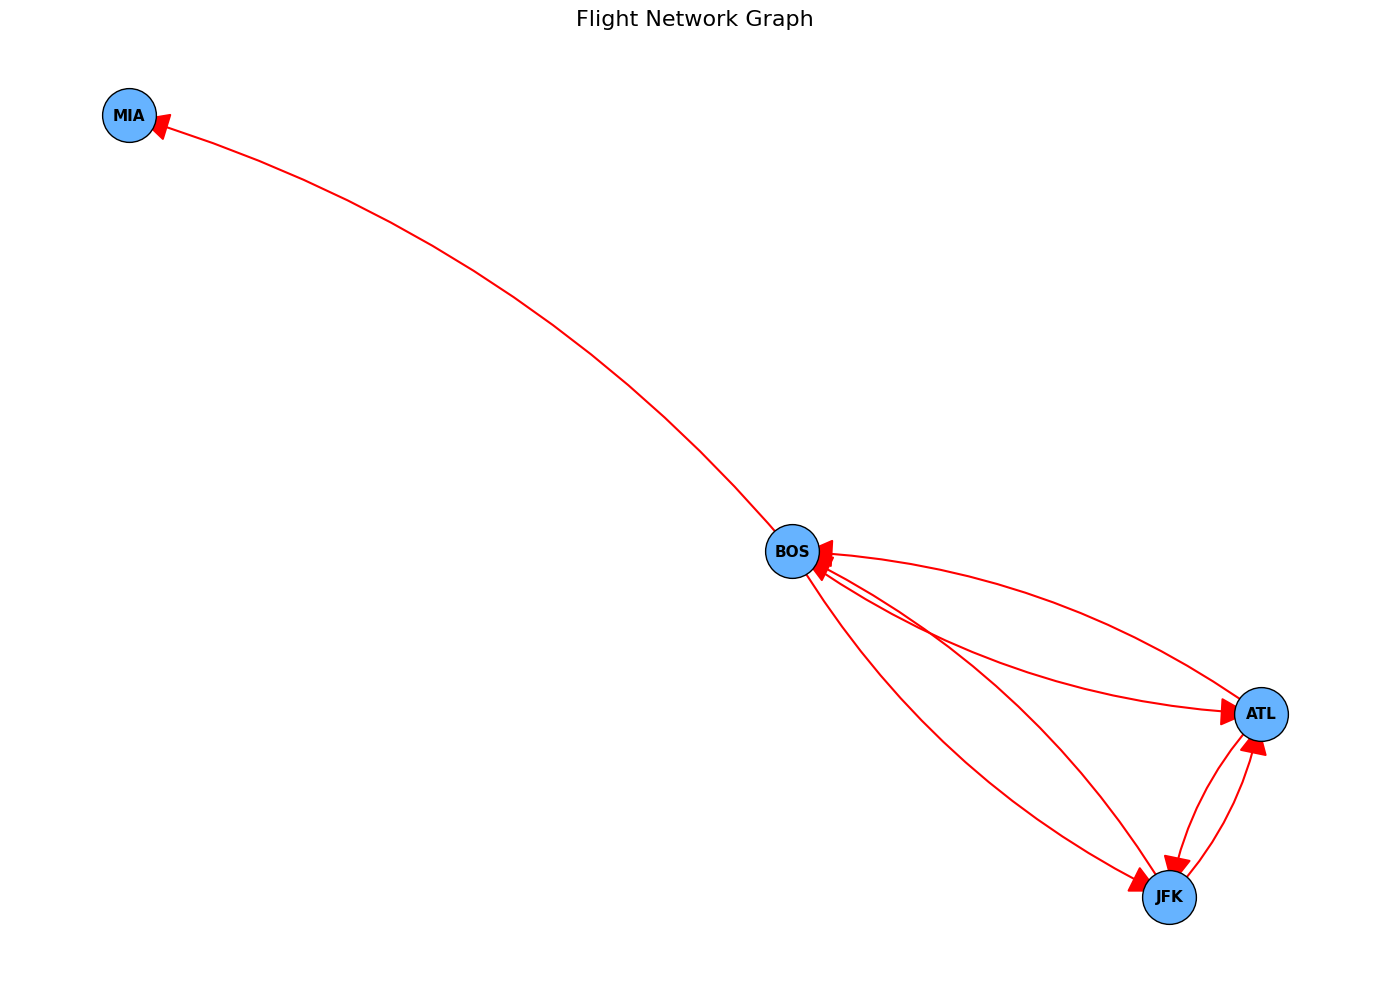

Graph has 4 nodes and 7 edges


In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph
G = nx.DiGraph()

# Add nodes (airports)
airports = set(flights_16qubit['origin'].unique()) | set(flights_16qubit['destination'].unique())
G.add_nodes_from(airports)

# Add edges (flights)
for _, flight in flights_16qubit.iterrows():
    G.add_edge(
        flight['origin'], 
        flight['destination'],
        weight=flight['cost']
    )

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=2)  # 'k' increases spacing between nodes

# 1. Draw Nodes
nx.draw_networkx_nodes(G, pos, node_color='#66b3ff', node_size=1500, edgecolors='black')

# 2. Draw Labels
nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold', font_family='sans-serif')

# 3. Draw Edges with visible arrows and curved lines
nx.draw_networkx_edges(
    G, 
    pos, 
    edge_color='red', 
    arrows=True, 
    arrowstyle='-|>',  # A sharper, cleaner arrow style
    arrowsize=45,      # Significantly larger arrows
    width=1.5,         # Thicker lines
    connectionstyle="arc3,rad=0.15" # Curves edges so bidirectional flights don't overlap
)

plt.title("Flight Network Graph", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

In [9]:
class MiniLabel:
    def __init__(self, node, time, cost, path):
        self.node, self.time, self.cost, self.path = node, time, cost, path[:]
    def __lt__(self, o): return self.cost < o.cost
    def dominates(self, o): 
        return self.node == o.node and self.time <= o.time and self.cost <= o.cost and (self.time < o.time or self.cost < o.cost)

def classical_16qubit(flights_df, origin, dest, max_time):
    graph = defaultdict(list)
    for _, f in flights_df.iterrows(): graph[f.origin].append(f)
    
    pq, labels = [], defaultdict(list)
    init = MiniLabel(origin, 0, 0, [origin])
    heapq.heappush(pq, init); labels[origin].append(init)
    
    best = None; explored = 0
    while pq:
        curr = heapq.heappop(pq); explored += 1
        labels[curr.node] = [l for l in labels[curr.node] if not curr.dominates(l) and l != curr]
        labels[curr.node].append(curr)
        
        if curr.node == dest:
            if best is None or curr.cost < best.cost: best = curr
            continue
        
        for f in graph[curr.node]:
            new_time = curr.time + f.duration_hours + 1.5
            if new_time > max_time: continue
            new_label = MiniLabel(f.destination, new_time, curr.cost + f.cost, curr.path + [f.destination])
            if not any(l.dominates(new_label) for l in labels[f.destination]):
                heapq.heappush(pq, new_label)
    
    print(f"Classical: {' → '.join(best.path) if best else 'No solution'} (${best.cost:.1f} if best else 'N/A')")
    return best

classical_optimal = classical_16qubit(flights_16qubit, scenario_16qubit['origin'], scenario_16qubit['destination'], scenario_16qubit['max_time'])
classical_cost = classical_optimal.cost if classical_optimal else float('inf')

Classical: JFK → BOS → MIA ($976.6 if best else 'N/A')


In [10]:
# def build_qubo(flights_df, origin, dest, max_time):
#     """3 constraints ONLY - guaranteed to work"""
#     n = len(flights_df)
#     Q = np.zeros((n, n))
    
#     A = 15.0  # Origin/Dest (strong)
#     B = 30.0  # Temporal (very strong) 
#     C = 5.0   # Sparsity (medium)
    
#     print("🔨 MINIMAL 3-CONSTRAINT QUBO...")
    
#     # 1. ORIGIN: Exactly 1 JFK departure
#     outs = [i for i,f in enumerate(flights_df.itertuples()) if f.origin == origin]
#     for i in outs: Q[i,i] -= A
#     for i in range(len(outs)):
#         for j in range(i+1,len(outs)):
#             u,v = outs[i],outs[j]
#             Q[u,v] += 2*A; Q[v,u] += 2*A
    
#     # 2. DESTINATION: Exactly 1 MIA arrival  
#     ins = [i for i,f in enumerate(flights_df.itertuples()) if f.destination == dest]
#     for i in ins: Q[i,i] -= A
#     for i in range(len(ins)):
#         for j in range(i+1,len(ins)):
#             u,v = ins[i],ins[j]
#             Q[u,v] += 2*A; Q[v,u] += 2*A
    
#     # 3. TEMPORAL: ONLY consecutive flights with ≥1.5h gap
#     violations = 0
#     for i in range(n):
#         fi = flights_df.iloc[i]
#         for j in range(n):
#             if i == j: continue
#             fj = flights_df.iloc[j]
#             if fi.destination == fj.origin:  # Must connect
#                 gap = (fj.departure_time - fi.arrival_time).total_seconds()/3600
#                 if gap < 1.5:  # Impossible
#                     Q[i,j] += B; Q[j,i] += B
#                     violations += 1
    
#     # 4. SPARSITY BIAS (CRITICAL)
#     for i in range(n):
#         Q[i,i] += C
    
#     print(f"Violations blocked: {violations} | Nonzeros: {np.count_nonzero(Q)}")
#     return Q


In [11]:
import numpy as np

def build_qubo(flights_df, origin, dest, max_time):
    n = len(flights_df)
    Q = np.zeros((n, n))
    
    # --- Tuned Weights ---
    # A: Must be large enough to force selection
    # B: Flow Reward (2*B = 16). 
    # C: Time Penalty (20). MUST be > 2*B to override bad connections.
    A_mandatory = 25.0  # Big reward for leaving origin (-25 energy)
    B_flow      = 12.0  # Big reward for connecting (-24 energy)
    C_temporal  = 30.0  # Penalty still higher than rewards, but manageable
    D_cost      = 1.0   # Cost is negligible noise
    
    print(f"🔨 Building QUBO (N={n}) with Fixed Weights...")

    # 1. Cost Minimization (Diagonal)
    # We normalize cost to be small (0.0 to 1.0) so it doesn't overpower constraints
    if flights_df['cost'].max() > 0:
        norm_costs = flights_df['cost'] / flights_df['cost'].max()
    else:
        norm_costs = flights_df['cost']
        
    for i in range(n):
        Q[i, i] += D_cost * norm_costs.iloc[i]

    # 2. Origin Constraint (Exactly 1 flight departing Origin)
    # Math: (Sum x - 1)^2  ->  Sum(x_i^2) + 2*Sum(x_i*x_j) - 2*Sum(x_i)
    # Since x^2 = x, Diagonal gets: +1 - 2 = -1
    outs = [i for i, f in enumerate(flights_df.itertuples()) if f.origin == origin]
    
    if not outs:
        print(f"⚠️  WARNING: No flights found departing '{origin}'! Check spelling.")
        
    for i in outs:
        Q[i, i] -= A_mandatory  # The Linear Reward (-A)
    for i in range(len(outs)):
        for j in range(i + 1, len(outs)):
            u, v = outs[i], outs[j]
            Q[u, v] += 2 * A_mandatory  # The Quadratic Penalty (+2A)

    # 3. Destination Constraint (Exactly 1 flight arriving Destination)
    ins = [i for i, f in enumerate(flights_df.itertuples()) if f.destination == dest]
    
    if not ins:
        print(f"⚠️  WARNING: No flights found arriving '{dest}'! Check spelling.")
        
    for i in ins:
        Q[i, i] -= A_mandatory
    for i in range(len(ins)):
        for j in range(i + 1, len(ins)):
            u, v = ins[i], ins[j]
            Q[u, v] += 2 * A_mandatory

    # 4. Flow Conservation (Intermediate Nodes)
    # Math: (In - Out)^2  ->  In^2 + Out^2 - 2*In*Out
    all_airports = set(flights_df['origin']) | set(flights_df['destination'])
    intermediate_hubs = all_airports - {origin, dest}
    
    for hub in intermediate_hubs:
        in_indices = [i for i, f in enumerate(flights_df.itertuples()) if f.destination == hub]
        out_indices = [i for i, f in enumerate(flights_df.itertuples()) if f.origin == hub]
        
        if not in_indices and not out_indices: continue

        # Term 1: +In^2 (Penalize multiple arrivals)
        for i in in_indices: Q[i, i] += B_flow
        for i in range(len(in_indices)):
            for j in range(i + 1, len(in_indices)):
                u, v = in_indices[i], in_indices[j]
                Q[u, v] += 2 * B_flow

        # Term 2: +Out^2 (Penalize multiple departures)
        for i in out_indices: Q[i, i] += B_flow
        for i in range(len(out_indices)):
            for j in range(i + 1, len(out_indices)):
                u, v = out_indices[i], out_indices[j]
                Q[u, v] += 2 * B_flow

        # Term 3: -2*In*Out (Reward for Connection)
        # We want -2*B total. Since we only write to Q[u,v] (upper), we just write -2*B once.
        for i in in_indices:
            for j in out_indices:
                # Ensure we write to Upper Triangular (row < col)
                u, v = min(i, j), max(i, j)
                if u == v: continue # Should not happen in DAG, but safety first
                Q[u, v] -= 2 * B_flow

    # 5. Temporal Constraints (The "Time Police")
    # If connection is Spatially Valid but Temporally Invalid -> Penalty
    for i in range(n):
        fi = flights_df.iloc[i]
        for j in range(i + 1, n): # Loop j > i only
            fj = flights_df.iloc[j]
            
            # Check both directions because i < j doesn't mean flight i is first
            
            # Case A: i -> j
            if fi.destination == fj.origin:
                gap = (fj.departure_time - fi.arrival_time).total_seconds() / 3600
                if gap < 1.5:
                    Q[i, j] += C_temporal
                    
            # Case B: j -> i
            elif fj.destination == fi.origin:
                gap = (fi.departure_time - fj.arrival_time).total_seconds() / 3600
                if gap < 1.5:
                    Q[i, j] += C_temporal

    # Normalize the entire matrix to range [-1, 1] for QAOA stability
    max_val = np.max(np.abs(Q))
    if max_val > 0:
        Q = Q / max_val
        print(f"✅ QUBO Normalized (Factor: {max_val:.1f})")
        
    return Q

In [12]:

print("="*60)
qubo = build_qubo(flights_16qubit, 
                                      scenario_16qubit['origin'], 
                                      scenario_16qubit['destination'], 
                                      scenario_16qubit['max_time'])


🔨 Building QUBO (N=14) with Fixed Weights...
✅ QUBO Normalized (Factor: 74.0)


In [13]:
max_val = np.max(np.abs(qubo))
qubo = qubo / max_val 

print(f"Original Max: {max_val} -> Scaled Max: {np.max(np.abs(qubo))}")

Original Max: 1.0 -> Scaled Max: 1.0


In [14]:
# Test your QUBO energy for key cases
qubo_test = qubo

def qubo_energy(x, Q):
    """Compute QUBO energy for bit vector x"""
    return x @ Q @ x

# Test cases
all_zero = np.zeros(14)
one_origin = np.zeros(14); one_origin[0] = 1  # Single origin flight
two_flights = np.zeros(14); two_flights[[0,9]] = 1  # Origin + connection
all_ones = np.ones(14)  # BAD solution

print("🔍 QUBO Energy Test:")
print(f"All zero:     {qubo_energy(all_zero, qubo_test):.1f}")
print(f"One flight:   {qubo_energy(one_origin, qubo_test):.1f}")
print(f"Two flights:  {qubo_energy(two_flights, qubo_test):.1f}")
print(f"ALL ONES:     {qubo_energy(all_ones, qubo_test):.1f}  ← SHOULD BE HIGH!")
print(f"ALL ONES:     {qubo_energy(sol, qubo_test):.1f}  ← SHOULD BE HIGH!")
# print(f"ALL ONES:     {qubo_energy(best_bit, qubo_test):.1f}  ← SHOULD BE HIGH!")


🔍 QUBO Energy Test:
All zero:     0.0
One flight:   -0.2
Two flights:  -0.7
ALL ONES:     16.9  ← SHOULD BE HIGH!


NameError: name 'sol' is not defined

In [15]:
import numpy as np1
import itertools

def qubo_energy(x, Q):
    """Compute QUBO energy for bit vector x"""
    return x @ Q @ x

n = 14
Q = qubo_test

min_energy = float("inf")
best_solutions = []

# Iterate over all 2^14 bit combinations
for bits in itertools.product([0, 1], repeat=n):
    x = np1.array(bits)
    energy = qubo_energy(x, Q)

    if energy < min_energy:
        min_energy = energy
        best_solutions = [x]
    elif energy == min_energy:
        best_solutions.append(x)

print("✅ QUBO Brute-Force Results")
print(f"Minimum energy: {min_energy:.3f}")
print(f"Number of optimal solutions: {len(best_solutions)}")

# Show a few best solutions
print("\nBest solution(s) (up to 5 shown):")
for sol in best_solutions[:5]:
    print(sol.astype(int))


✅ QUBO Brute-Force Results
Minimum energy: -0.656
Number of optimal solutions: 1

Best solution(s) (up to 5 shown):
[1 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def qubo_to_ising(Q):

    """
    Converts a QUBO matrix Q into Ising Hamiltonian parameters J and h.
    Mapping: x_i = (1 - s_i) / 2
    """
    n = Q.shape[0]
    h = np.zeros(n)      # Linear biases (external field)
    J = np.zeros((n, n)) # Quadratic couplings (interactions)
    offset = 0           # Constant energy offset (irrelevant for optimization but good for physics)

    for i in range(n):
        # Handle Diagonal Terms (Linear in QUBO)
        # Q_ii * x_i  =>  Q_ii * (0.5 - 0.5 * s_i)
        offset += 0.5 * Q[i, i]
        h[i] += -0.5 * Q[i, i]
        
        for j in range(n):
            if i == j: continue
            
            # Handle Off-Diagonal Terms (Quadratic in QUBO)
            # Q_ij * x_i * x_j => Q_ij * (1-s_i)/2 * (1-s_j)/2
            # Expand: 0.25*Q_ij - 0.25*Q_ij*s_i - 0.25*Q_ij*s_j + 0.25*Q_ij*s_i*s_j
            val = Q[i, j]
            if val != 0:
                offset += 0.25 * val
                h[i] += -0.25 * val # Influence on s_i
                h[j] += -0.25 * val # Influence on s_j (redundant if loop covers j,i, but safe here)
                J[i, j] += 0.25 * val

    return J, h, offset

# --- 3. Visualization Function ---
def plot_qubo_and_ising(Q, J, h):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Setup common plotting kwargs
    heatmap_args = {'cmap': 'RdBu', 'center': 0, 'annot': True, 'fmt': '.0f'}
    
    # 1. Plot QUBO
    sns.heatmap(Q, ax=axes[0], **heatmap_args)
    axes[0].set_title('QUBO Matrix (Binary $x \in \{0,1\}$)', fontsize=14)
    axes[0].set_xlabel('Variable $x_j$')
    axes[0].set_ylabel('Variable $x_i$')
    
    # 2. Plot Ising Couplings (J)
    # J is usually smaller, so use fmt='.1f'
    heatmap_args['fmt'] = '.1f' 
    sns.heatmap(J, ax=axes[1], **heatmap_args)
    axes[1].set_title('Ising Couplings $J_{ij}$ (Spin $s \in \{-1, +1\}$)', fontsize=14)
    axes[1].set_xlabel('Spin $s_j$')
    axes[1].set_ylabel('Spin $s_i$')

    # 3. Plot Ising Biases (h)
    # Reshape h for heatmap (n x 1)
    sns.heatmap(h.reshape(-1, 1), ax=axes[2], cmap='RdBu', center=0, annot=True, fmt='.1f', cbar=True)
    axes[2].set_title('Ising Biases $h_i$ (Magnetic Field)', fontsize=14)
    axes[2].set_xticks([]) # Hide x-ticks for vector
    axes[2].set_ylabel('Spin $s_i$')

    plt.tight_layout()
    plt.show()

<>:46: SyntaxWarning: invalid escape sequence '\i'
<>:54: SyntaxWarning: invalid escape sequence '\i'
<>:46: SyntaxWarning: invalid escape sequence '\i'
<>:54: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-1318407717.py:46: SyntaxWarning: invalid escape sequence '\i'
  axes[0].set_title('QUBO Matrix (Binary $x \in \{0,1\}$)', fontsize=14)
/tmp/ipython-input-1318407717.py:54: SyntaxWarning: invalid escape sequence '\i'
  axes[1].set_title('Ising Couplings $J_{ij}$ (Spin $s \in \{-1, +1\}$)', fontsize=14)


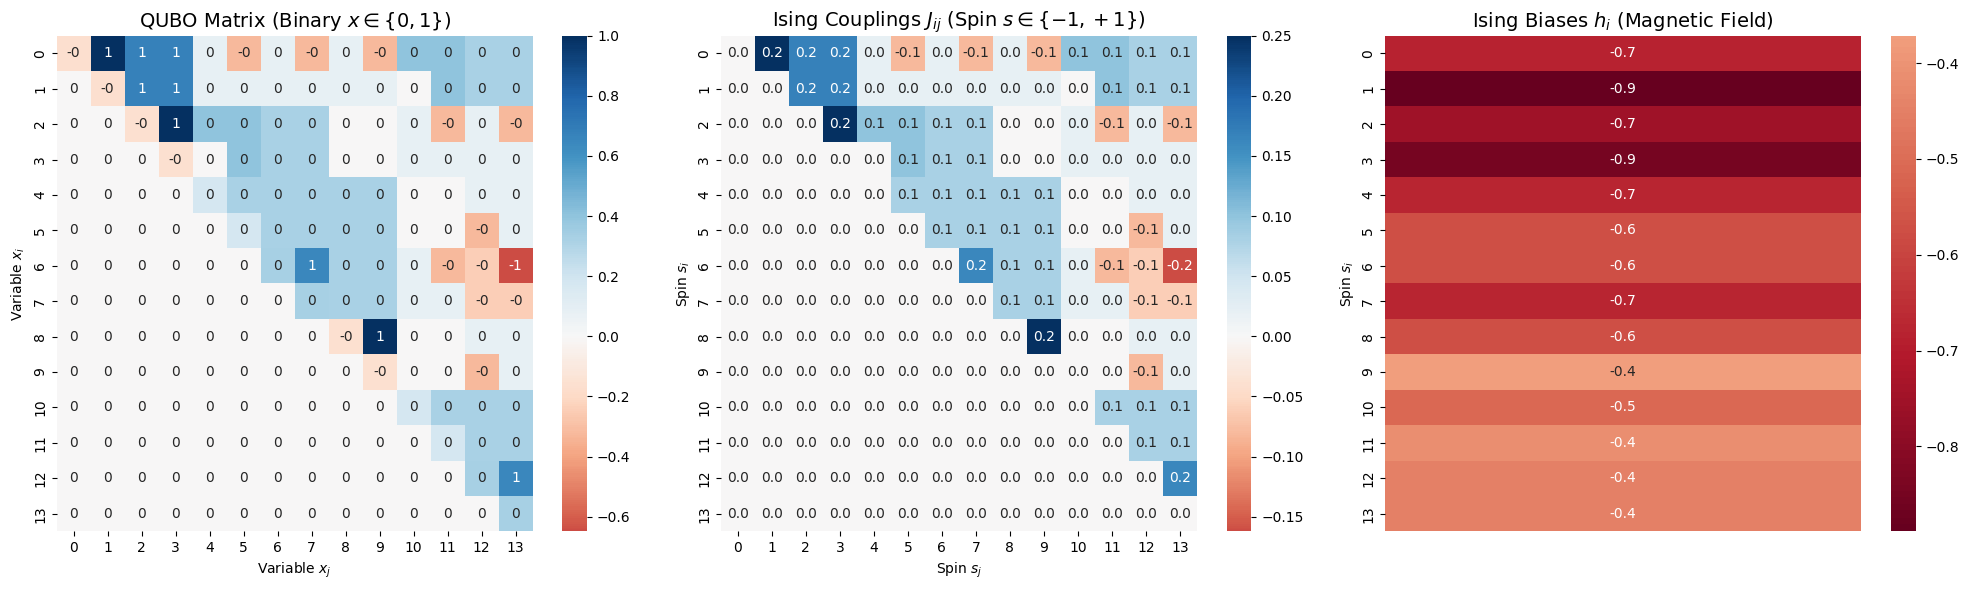

In [19]:
J_matrix, h_vector, offset = qubo_to_ising(qubo)
plot_qubo_and_ising(qubo, J_matrix, h_vector)

In [20]:
import pennylane as qml
from pennylane import numpy as np
def qubo_to_ham(Q):
    n_qubits = Q.shape[0]
    coeffs, ops = [], []
    
    # We assume Q is symmetric. If not, this logic requires symmetrization.
    # H = Sum(h_i Z_i) + Sum(J_ij Z_i Z_j)
    
    for i in range(n_qubits):
        # Calculate h_i
        # Contribution from diagonal: Q_ii * (1-Z_i)/2  -> coeff is -Q_ii/2
        # Contribution from off-diag: Q_ij * (1-Z_i)/2 * (1-Z_j)/2 
        # -> -Q_ij/4 * Z_i  (summed over j)
        
        h_term = -0.5 * Q[i, i]
        for j in range(n_qubits):
            if i != j:
                h_term -= 0.25 * (Q[i, j] + Q[j, i]) # Add both triangles
        
        if abs(h_term) > 1e-8:
            coeffs.append(h_term)
            ops.append(qml.PauliZ(i))
            
    for i in range(n_qubits):
        for j in range(i + 1, n_qubits):
            # Calculate J_ij
            # Contribution from off-diag: Q_ij/4 * Z_i * Z_j
            
            J_term = 0.25 * (Q[i, j] + Q[j, i])
            
            if abs(J_term) > 1e-8:
                coeffs.append(J_term)
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
                
    return qml.Hamiltonian(coeffs, ops)

In [21]:
hamiltonian = qubo_to_ham(qubo)

n_qubits = len(flights_16qubit) 
print(f"Detected N={n_qubits} flights. Adjusting quantum device...")

# --- 2. Setup Device with Dynamic Wires ---
dev = qml.device('default.qubit', wires=n_qubits)

# --- 3. Re-Generate Hamiltonian (Safety Check) ---
# Ensure Q matches the dataframe size


# --- 4. Define Dynamic QAOA Circuit ---
# checking n_qubits, not 16!
def qaoa_circuit(params):
    # Apply Hadamard to ALL qubits
    for i in range(n_qubits): 
        qml.Hadamard(wires=i)
        
    for l in range(2): # p=2 layers
        qml.ApproxTimeEvolution(hamiltonian, params[2*l], n=1)
        # Apply Mixer to ALL qubits
        for i in range(n_qubits): 
            qml.RX(2*params[2*l+1], wires=i)

@qml.qnode(dev)
def cost_fn(params): 
    qaoa_circuit(params)
    return qml.expval(hamiltonian)

# --- 5. Run Optimization ---
opt = qml.AdamOptimizer(stepsize=0.1)
params = np.array([0.1, 0.1, 0.1, 0.1], requires_grad=True)

print(f"🚀 Optimizing {n_qubits}-qubit QAOA...")
for i in range(60):
    params, cost = opt.step_and_cost(cost_fn, params)
    if i % 10 == 0:
        print(f"Step {i}: Cost = {cost:.4f}")

# --- 6. Sample Result ---
@qml.qnode(dev, shots=2048)
def sample_fn(params):
    qaoa_circuit(params)
    return qml.sample()

samples = sample_fn(params)
# bitstrings = ["".join(map(str, s)) for s in samples]
# best_state = Counter(bitstrings).most_common(1)[0][0]

# print(f"\n🏆 Best Candidate: {best_state}")
# selected_flights = [i for i, bit in enumerate(best_state) if bit == '1']
# print(f"Selected Flight Indices: {selected_flights}")

Detected N=14 flights. Adjusting quantum device...
🚀 Optimizing 14-qubit QAOA...
Step 0: Cost = 0.8054
Step 10: Cost = 0.0111
Step 20: Cost = -3.9107
Step 30: Cost = -3.7727
Step 40: Cost = -4.2632
Step 50: Cost = -4.3632


In [22]:
import collections

# Get the raw samples from your device/simulator
# Assuming 'samples' contains your shots (e.g., from qml.sample)
# If you don't have 'samples' variable, re-run the sampling part:
# samples = circuit(params, shots=1000) 

bitstrings = ["".join(map(str, s)) for s in samples]
counts = collections.Counter(bitstrings)

print(len(counts.keys()), "unique bitstrings found.")

print("\n🔍 TOP 10 CANDIDATES (Look for non-zeros!):")
print("-" * 40)
min = 0
for bitstring, freq in counts.most_common(10):

    x = np.array([int(b) for b in bitstring])
    energy = x.T @ qubo @ x 


    if energy < min: 
        print(print(f"Bits: {bitstring} | Count: {freq:3d} | Energy: {energy:.4f}"))
        min = energy
        best_state = bitstring

263 unique bitstrings found.

🔍 TOP 10 CANDIDATES (Look for non-zeros!):
----------------------------------------
Bits: 00000000010000 | Count: 168 | Energy: -0.1631
None
Bits: 10000000000000 | Count:  59 | Energy: -0.1682
None
Bits: 10000000010000 | Count:  53 | Energy: -0.6556
None


In [23]:
def decode_qaoa_solution(bitstring, flights_df, origin, destination):
    # 1. Parse the bitstring (No reversal!)
    n_flights = len(flights_df)
    selected_indices = [i for i in range(len(bitstring)) if bitstring[i] == '1']
    
    print(f"🔍 Decoding bitstring '{bitstring}'...")
    print(f"   Raw selection: {selected_indices} ({len(selected_indices)} flights)")
    
    # 2. Get flights and sort chronologically
    selected_flights = [flights_df.iloc[i] for i in selected_indices]
    selected_flights.sort(key=lambda f: f['departure_time'])
    
    # 3. Path reconstruction state
    path = [origin]
    current_node = origin
    # Start time is effectively 0 or the first flight's departure
    # We track arrival time of the previous flight
    last_arrival_time = None 
    
    valid_sequence = []
    total_cost = 0
    total_violations = 0
    
    print(f"   Chronological processing:")
    
    for i, flight in enumerate(selected_flights):
        flight_info = f"F{flight.name}: {flight['origin']}->{flight['destination']} @ {flight['departure_time'].strftime('%H:%M')}"
        
        # --- CHECK 1: Location Continuity ---
        if flight['origin'] != current_node:
            flight_info += f" ❌ WRONG ORIGIN (Exp: {current_node})"
            total_violations += 1
            print(f"     {flight_info}")
            continue # Skip this flight, it breaks the chain

        # --- CHECK 2: Temporal Feasibility ---
        # If we have flown before, we must arrive + 1.5h handling BEFORE this flight departs
        if last_arrival_time is not None:
            min_departure = last_arrival_time + timedelta(hours=1.5)
            if flight['departure_time'] < min_departure:
                flight_info += f" ❌ TOO SOON (Need {min_departure.strftime('%H:%M')})"
                total_violations += 1
                print(f"     {flight_info}")
                continue # Skip this flight, impossible connection

        # --- Valid Step ---
        valid_sequence.append(flight)
        total_cost += flight['cost']
        path.append(flight['destination'])
        
        # Update State
        current_node = flight['destination']
        last_arrival_time = flight['arrival_time']
        flight_info += " ✅"
        print(f"     {flight_info}")

    # 4. Final Solution Checks
    reached_destination = (path[-1] == destination)
    
    print(f"\n📋 RECONSTRUCTED PATH:")
    print(f"   {' → '.join(path)}")
    print(f"   Reached dest: {'✅' if reached_destination else '❌'}")
    print(f"   Valid flights: {len(valid_sequence)}")
    print(f"   Ignored/Violations: {total_violations}")
    
    if reached_destination and total_violations == 0:

        t_start = valid_sequence[0]['departure_time']
        t_end = valid_sequence[-1]['arrival_time']
        total_time = (t_end - t_start).total_seconds() / 3600.0
        
        print(f"\n🎯 VALID SOLUTION FOUND!")
        print(f"   Cost: ${total_cost:.0f}")
        return True, total_cost, total_time, valid_sequence, path
    else:
        print(f"\n⚠️  INVALID PATH (Breaks continuity or time)")
        return False, total_cost, 0, [], path
# === EXTRACT YOUR QAOA SOLUTION ===
print("🔍 EXTRACTING YOUR QAOA SOLUTION:")


print(f"Best bitstring: '{best_state}' (frequency: {counts[best_state]/1024*100:.1f}%)")


solution_valid, solution_cost, solution_time, valid_flights, solution_path = decode_qaoa_solution(
    best_state, flights_16qubit, scenario_16qubit['origin'], scenario_16qubit['destination']
)


🔍 EXTRACTING YOUR QAOA SOLUTION:
Best bitstring: '10000000010000' (frequency: 5.2%)
🔍 Decoding bitstring '10000000010000'...
   Raw selection: [0, 9] (2 flights)
   Chronological processing:
     F0: JFK->BOS @ 08:00 ✅
     F11: BOS->MIA @ 14:00 ✅

📋 RECONSTRUCTED PATH:
   JFK → BOS → MIA
   Reached dest: ✅
   Valid flights: 2
   Ignored/Violations: 0

🎯 VALID SOLUTION FOUND!
   Cost: $977
